In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-287b2312-b917-f02c-a6bf-33c5964a779f)


In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 8.65 MiB/s, done.
Updating files: 100% (13/13), done.


In [ ]:
!ls /content/pubmed-rct/

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
!ls /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
!ls /content/pubmed-rct/PubMed_20k_RCT/

dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


In [ ]:
data_dir="pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
def get_lines(filename):
  with open(filename,"r") as f:
    return f.readlines()


In [ ]:
train_line=get_lines(data_dir+"train.txt")
train_line[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_line)

210040

In [ ]:
train_line[2]

'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n'

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) 
  abstract_lines = "" 
  abstract_samples = [] 
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): 
      abstract_id = line
      abstract_lines = "" 
    elif line.isspace(): 
      abstract_line_split = abstract_lines.splitlines() 

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} 
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples





In [ ]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 564 ms, sys: 94.4 ms, total: 658 ms
Wall time: 1.1 s


(180040, 30212, 30135)

In [ ]:
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [ ]:
import pandas as pd
train_df=pd.DataFrame(train_samples)
val_df=pd.DataFrame(val_samples)
test_df=pd.DataFrame(test_samples)
train_df.head(10)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

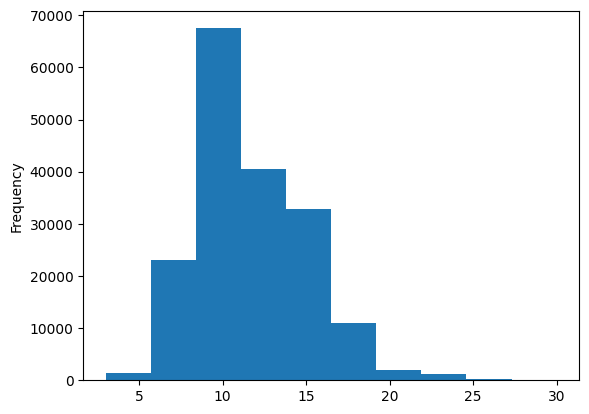

In [ ]:
train_df.total_lines.plot(kind="hist");

#**Get list of sentences**

In [ ]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

#**Make numeric labels (ML models require numeric labels)**

##**One Hot encode labels**

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
One_Hot_Encoder=OneHotEncoder(sparse_output=False)
train_labels_one_hot=One_Hot_Encoder.fit_transform(train_df.target.to_numpy().reshape(-1, 1))
val_labels_one_hot=One_Hot_Encoder.fit_transform(val_df.target.to_numpy().reshape(-1, 1))
test_labels_one_hot=One_Hot_Encoder.fit_transform(test_df.target.to_numpy().reshape(-1, 1))

In [ ]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

##**Label encode labels**

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names
     

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

#**Create Model**

##**model_0**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [ ]:

model_0=Pipeline([
    ("tf-idf",TfidfVectorizer()),
    ("clf",MultinomialNB())
    ])

model_0_history=model_0.fit(train_sentences,train_labels_encoded )

In [ ]:
model_0_history

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

###**Model_0 score**

In [ ]:
model_0_score=model_0.score(val_sentences,val_labels_encoded)
model_0_score

0.7218323844829869

In [ ]:

# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-05-10 16:14:20--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-05-10 16:14:20 (108 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

###**Model_0 results**

In [ ]:
Model_0_results=calculate_results(val_labels_encoded,baseline_preds)
Model_0_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

##**Preparing our data for deep sequence models**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
len_sentences=[len(sentence.split()) for sentence in train_sentences]
avg_sent_len=np.mean(len_sentences)
avg_sent_len

26.338269273494777

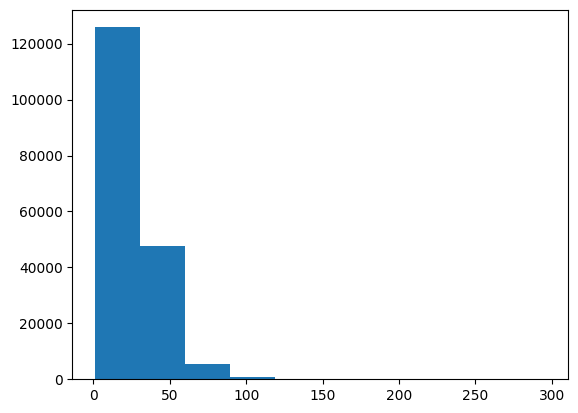

In [ ]:
import matplotlib.pyplot as plt
plt.hist(len_sentences);

In [ ]:
output_seq_len=int(np.percentile(len_sentences,95))
output_seq_len

55

In [ ]:
max(len_sentences)

296

##**Create text vectorizer**

In [ ]:
max_tocken=68000

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
text_vectorizer=TextVectorization(max_tokens=max_tocken,
                                  output_sequence_length=output_seq_len)

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:

# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

##**Create custom text embedding**

In [ ]:
token_embedded=layers.Embedding(input_dim=len(rct_20k_text_vocab),
                                output_dim=128, 
                                embeddings_initializer='uniform', 
                                embeddings_regularizer=None,
                                activity_regularizer=None, 
                                embeddings_constraint=None,
                                mask_zero=True, 
                                input_length=None,
                                sparse=False)

In [ ]:
import random
target_sentence=random.choice(train_sentences)
print(f"\nsample :\n{target_sentence}\n")

print(f"length of Text :\n{len(target_sentence.split())}\n")

print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embedded(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")


sample :
we sought to investigate whether the addition of high-dose inhaled budesonide to standard therapy would shorten the length of stay ( los ) in hospital of children admitted for asthma exacerbations .

length of Text :
32

Sentence before vectorization:
we sought to investigate whether the addition of high-dose inhaled budesonide to standard therapy would shorten the length of stay ( los ) in hospital of children admitted for asthma exacerbations .

Sentence after vectorization (before embedding):
[[  43 1193    6  331  180    2  333    4 1350 1736 3144    6  165   66
   495 6469    2  523    4  603 4154    5  237    4  109 1748   11  569
  1787    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[-0.01171635 -0.03480401 -0.00828853 ... -0.01199976  0.02148874
    0.02651915]
  [-0.03084151  0.03359816  0.01992707 ... -0.04167321  0.03483187
   -0.0371449 ]
  [ 0.01970

##**Create datasets (as fast as possible)**

In [ ]:
train_dataset=tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
val_dataset=tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset=tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Turn our data into TensorFlow Datasets
train_dataset =train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset =val_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

##**Model_1: Conv1D with token embeddings**

In [ ]:
inputs=layers.Input(shape=(1,),dtype="string")
x=text_vectorizer(inputs)
x=token_embedded(x)
x=layers.Conv1D(filters=64, kernel_size=5,strides=1, padding='same', activation="relu") (x)
x=layers.GlobalAveragePooling1D() (x)
outputs=layers.Dense(num_classes,activation="softmax") (x)
model_1=tf.keras.Model(inputs,outputs)

In [ ]:
# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 55, 128)           8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), 
                              epochs=5,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/5
562/562 [==============================] - 45s 61ms/step - loss: 0.9122 - accuracy: 0.6399 - val_loss: 0.6838 - val_accuracy: 0.7384
Epoch 2/5
562/562 [==============================] - 7s 13ms/step - loss: 0.6589 - accuracy: 0.7539 - val_loss: 0.6315 - val_accuracy: 0.7736
Epoch 3/5
562/562 [==============================] - 6s 10ms/step - loss: 0.6190 - accuracy: 0.7739 - val_loss: 0.5983 - val_accuracy: 0.7856
Epoch 4/5
562/562 [==============================] - 4s 7ms/step - loss: 0.5912 - accuracy: 0.7878 - val_loss: 0.5833 - val_accuracy: 0.7826
Epoch 5/5
562/562 [==============================] - 6s 10ms/step - loss: 0.5917 - accuracy: 0.7921 - val_loss: 0.5630 - val_accuracy: 0.7955


###**mode_1 score**

In [ ]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5617 - accuracy: 0.8004


[0.5617009401321411, 0.8004435300827026]

In [ ]:
model_1_prob=model_1.predict(valid_dataset)
model_1_prob[:10]

945/945 [==============================] - 3s 3ms/step


array([[5.3831136e-01, 1.8038909e-01, 3.8673587e-02, 1.8330720e-01,
        5.9318699e-02],
       [4.3591601e-01, 3.6223635e-01, 2.6436804e-02, 1.3389251e-01,
        4.1518401e-02],
       [1.8040617e-01, 4.9950751e-03, 1.5421221e-03, 8.1300676e-01,
        4.9846771e-05],
       [4.4807413e-05, 2.0266022e-04, 9.9882466e-01, 5.7715097e-05,
        8.7019597e-04],
       [5.1471270e-03, 8.1153527e-02, 6.4790553e-01, 2.9037734e-03,
        2.6289001e-01],
       [1.5906814e-02, 1.8356293e-02, 6.8226856e-01, 6.3148285e-03,
        2.7715343e-01],
       [1.0436013e-03, 2.6882316e-03, 6.5298778e-01, 5.8040110e-04,
        3.4270000e-01],
       [3.8574200e-02, 3.7397355e-02, 5.4229069e-01, 1.5274819e-02,
        3.6646286e-01],
       [1.5168815e-10, 7.6331662e-07, 1.7343334e-06, 1.8793862e-10,
        9.9999750e-01],
       [1.1377475e-02, 8.1124252e-01, 6.1183386e-02, 2.4031159e-02,
        9.2165455e-02]], dtype=float32)

In [ ]:
model_1_pred=tf.argmax(model_1_prob, axis=1)
model_1_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

###**Model_1 results**

In [ ]:
Model_1_results=calculate_results(val_labels_encoded,model_1_pred)
Model_1_results

{'accuracy': 80.04435323712433,
 'precision': 0.7999460471071541,
 'recall': 0.8004435323712432,
 'f1': 0.7972367142528713}

##**Model 2: Feature extraction with pretrained token embeddings**

In [ ]:
import tensorflow_hub as hub
tf_hub_embedded_layer=hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                     trainable=False,
                                     name="universal-sentence-encoder")

In [ ]:
#Test out the embedding on a random sentence

random_sentence=random.choice(train_sentences)
USE_embedded_sentence=tf_hub_embedded_layer([random_sentence])
print(f"random_sentence :\n {random_sentence}\n")
print(f"random_sentence after univrsal-sentence-encoder :\n{USE_embedded_sentence[0][:30]}")

random_sentence :
 the outcomes assessed in t@ , t@ , t@ , t@ , and t@ weeks were visual analog scale for pain and for swelling , chronic disease activity index , goniometry , simplified stanford health assessment questionnaire , and side effects .

random_sentence after univrsal-sentence-encoder :
[-0.05527005 -0.06643958 -0.01508225  0.06361236  0.00808794  0.00445357
 -0.04891497 -0.01483083  0.03786776  0.03914238  0.07963102 -0.03231954
  0.05154299 -0.02003165 -0.04699602 -0.04111566 -0.08076069  0.04506535
  0.01341213 -0.03226072  0.023226    0.04897913 -0.07168098  0.00391109
 -0.01823523  0.04330437 -0.03217483 -0.03998012 -0.0453674  -0.01606009]


In [ ]:
inputs=layers.Input(shape=[],dtype=tf.string)
embedded_layer=tf_hub_embedded_layer(inputs)
x=layers.Dense(128,activation="relu")(embedded_layer)
outputs=layers.Dense(5,activation="softmax")(x)
model_2=tf.keras.Model(inputs,outputs)

In [ ]:
# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal-sentence-encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit the model
model_2_history = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), 
                              epochs=5,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/5
562/562 [==============================] - 11s 15ms/step - loss: 0.9131 - accuracy: 0.6515 - val_loss: 0.7993 - val_accuracy: 0.6882
Epoch 2/5
562/562 [==============================] - 9s 15ms/step - loss: 0.7709 - accuracy: 0.7011 - val_loss: 0.7575 - val_accuracy: 0.7068
Epoch 3/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7564 - accuracy: 0.7101 - val_loss: 0.7432 - val_accuracy: 0.7128
Epoch 4/5
562/562 [==============================] - 8s 14ms/step - loss: 0.7234 - accuracy: 0.7233 - val_loss: 0.7155 - val_accuracy: 0.7284
Epoch 5/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7312 - accuracy: 0.7210 - val_loss: 0.6937 - val_accuracy: 0.7364


###**mode_2 score**

In [ ]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.7026 - accuracy: 0.7328


[0.7025993466377258, 0.732755184173584]

In [ ]:
model_2_prob=model_2.predict(valid_dataset)
model_2_prob[:10]

945/945 [==============================] - 10s 10ms/step


array([[6.19569957e-01, 2.56673515e-01, 3.32224485e-03, 1.09851457e-01,
        1.05829053e-02],
       [4.34505820e-01, 4.81026679e-01, 5.77088352e-03, 7.62960091e-02,
        2.40063597e-03],
       [3.54360044e-01, 6.10842630e-02, 4.00573425e-02, 5.03697872e-01,
        4.08004634e-02],
       [7.35490955e-03, 1.59957074e-02, 9.24848080e-01, 5.03344042e-03,
        4.67678010e-02],
       [1.15125235e-02, 1.33620694e-01, 4.62182164e-01, 4.44767950e-03,
        3.88236910e-01],
       [4.01813217e-04, 1.06986065e-03, 7.71700382e-01, 4.71412532e-05,
        2.26780802e-01],
       [1.11852237e-03, 2.35755579e-03, 6.54098332e-01, 9.67714237e-04,
        3.41457814e-01],
       [2.24069459e-03, 1.65456403e-02, 6.80445611e-01, 4.99898160e-04,
        3.00268173e-01],
       [6.34490454e-04, 4.71714744e-03, 2.85481196e-02, 9.10649891e-04,
        9.65189636e-01],
       [1.85058296e-01, 5.20762563e-01, 7.97913969e-02, 5.47571480e-02,
        1.59630597e-01]], dtype=float32)

In [ ]:
model_2_pred=tf.argmax(model_2_prob, axis=1)
model_2_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

###**Model_2 results**

In [ ]:
Model_2_results=calculate_results(val_labels_encoded,model_2_pred)
Model_2_results

{'accuracy': 73.27551966106182,
 'precision': 0.7291041625289939,
 'recall': 0.7327551966106183,
 'f1': 0.7270759993419815}

##**Model 3: Conv1D with character embeddings**

###**Creating a character-level tokenize**

In [ ]:
def split_char(text):
  return " ".join(list(text))

In [ ]:
split_char(random_sentence)

't h e   o u t c o m e s   a s s e s s e d   i n   t @   ,   t @   ,   t @   ,   t @   ,   a n d   t @   w e e k s   w e r e   v i s u a l   a n a l o g   s c a l e   f o r   p a i n   a n d   f o r   s w e l l i n g   ,   c h r o n i c   d i s e a s e   a c t i v i t y   i n d e x   ,   g o n i o m e t r y   ,   s i m p l i f i e d   s t a n f o r d   h e a l t h   a s s e s s m e n t   q u e s t i o n n a i r e   ,   a n d   s i d e   e f f e c t s   .'

In [ ]:
train_char=[split_char(sentence)for sentence in train_sentences ]
val_char=[split_char(sentence)for sentence in val_sentences ]
test_char=[split_char(sentence)for sentence in test_sentences ]

In [ ]:
train_char[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
char_len=[len(sentence) for sentence in train_sentences]
mean_char_len=np.mean(char_len)
mean_char_len

149.3662574983337

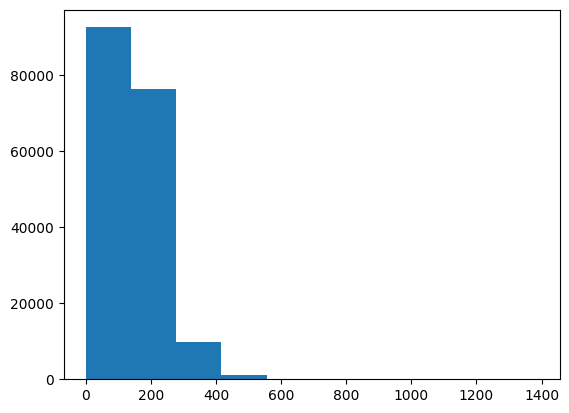

In [ ]:
plt.hist(char_len);

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_len, 95))
output_seq_char_len

290

In [ ]:
import string
alphabet=string.ascii_lowercase+string.digits+string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_char)

In [ ]:
char_vocab=char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


###**Creating a character-level embedding**

In [ ]:

# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

###**Building a Conv1D model to fit on character embeddings**

In [ ]:
inputs=layers.Input(shape=(1,),dtype="string")
x=char_vectorizer(inputs)
x=char_embed(x)
x=layers.Conv1D(filters=64, kernel_size=5,strides=1, padding='same', activation="relu") (x)
x=layers.GlobalMaxPooling1D() (x)
outputs=layers.Dense(num_classes,activation="softmax") (x)
model_3=tf.keras.Model(inputs,outputs)

In [ ]:
# Compile
model_3.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5)                 325 

In [ ]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_char, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_char, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)), 
                              epochs=5,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/5
562/562 [==============================] - 3s 5ms/step - loss: 1.2041 - accuracy: 0.5046 - val_loss: 1.0203 - val_accuracy: 0.5964
Epoch 2/5
562/562 [==============================] - 3s 5ms/step - loss: 0.9952 - accuracy: 0.6028 - val_loss: 0.9299 - val_accuracy: 0.6340
Epoch 3/5
562/562 [==============================] - 4s 7ms/step - loss: 0.9195 - accuracy: 0.6388 - val_loss: 0.8728 - val_accuracy: 0.6546
Epoch 4/5
562/562 [==============================] - 3s 5ms/step - loss: 0.8683 - accuracy: 0.6637 - val_loss: 0.8395 - val_accuracy: 0.6799
Epoch 5/5
562/562 [==============================] - 3s 5ms/step - loss: 0.8616 - accuracy: 0.6658 - val_loss: 0.8223 - val_accuracy: 0.6828


###**Model_3 score** bold text

In [ ]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.8344 - accuracy: 0.6802


[0.8343874216079712, 0.680193305015564]

In [ ]:
model_3_prob=model_3.predict(val_char_dataset)
model_3_prob[:10]

945/945 [==============================] - 3s 4ms/step


array([[2.00274900e-01, 4.35946584e-01, 1.08494163e-01, 2.25958809e-01,
        2.93256249e-02],
       [2.19737947e-01, 6.67050779e-01, 1.14637986e-02, 9.61097404e-02,
        5.63772256e-03],
       [1.98147014e-01, 1.17505766e-01, 3.05538625e-02, 6.49543941e-01,
        4.24944190e-03],
       [1.61447246e-02, 1.35855861e-02, 9.26677883e-01, 8.38901196e-03,
        3.52027752e-02],
       [1.09690251e-02, 5.99724054e-02, 7.24008203e-01, 2.49069836e-02,
        1.80143386e-01],
       [2.02265030e-04, 4.34612681e-04, 7.56407797e-01, 1.54176552e-04,
        2.42801160e-01],
       [4.50036954e-03, 2.22196560e-02, 7.75553882e-01, 1.49639894e-03,
        1.96229756e-01],
       [1.80389360e-01, 4.11848068e-01, 1.06054999e-01, 1.25483632e-01,
        1.76223949e-01],
       [1.70801638e-03, 1.31288860e-02, 1.81882024e-01, 6.20798767e-03,
        7.97073126e-01],
       [2.01981977e-01, 2.00311884e-01, 3.15257847e-01, 1.22218065e-01,
        1.60230219e-01]], dtype=float32)

In [ ]:
model_3_pred=tf.argmax(model_3_prob, axis=1)
model_3_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 2, 1])>

###**Model_3 results**

In [ ]:
Model_3_results=calculate_results(val_labels_encoded,model_3_pred)
Model_3_results

{'accuracy': 68.01933006752284,
 'precision': 0.6841004296634118,
 'recall': 0.6801933006752284,
 'f1': 0.6769261571968442}

##**Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)**

In [ ]:
from os import name
#Setup token inputs/model
token_inputs=layers.Input(shape=[],dtype=tf.string,name="token_inputs")
token_embedded=tf_hub_embedded_layer(token_inputs)
token_outputs=layers.Dense(128,activation="relu")(token_embedded)
token_model=tf.keras.Model(token_inputs,token_outputs)

char_inputs=layers.Input(shape=(1,),dtype=tf.string,name="char_inputs")
char_vector=char_vectorizer(char_inputs)
char_embedding=char_embed(char_vector)
char_bi_lstm=layers.Bidirectional(layers.LSTM(25)) (char_embedding)
char_model=tf.keras.Model(char_inputs,char_bi_lstm)

#concatenate both model

token_char_concatenate=layers.Concatenate(name="Concatenate_Layer")([token_model.output,char_model.output])

combined_dropout = layers.Dropout(0.5)(token_char_concatenate)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) 
final_dropout = layers.Dropout(0.5)(combined_dense)
outputs = layers.Dense(num_classes, activation="softmax")(final_dropout)

model_4=tf.keras.Model(inputs=[token_model.input,char_model.input],
                       outputs=outputs,name="model_4_token_and_char_embeddings")

In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal-sentence-encoder (Ke  (None, 512)         256797824   [

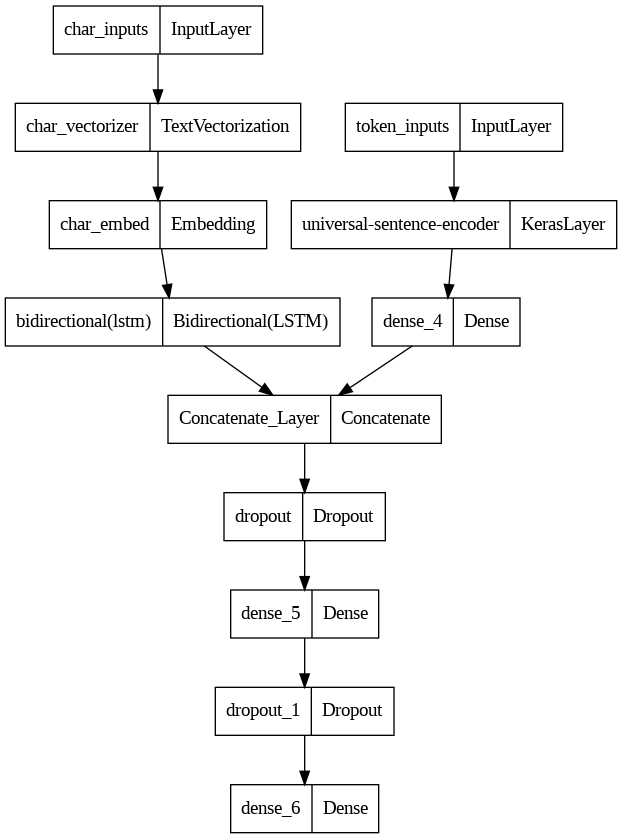

In [ ]:

# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [ ]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

###**Combining token and character data into a tf.data dataset**

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_char)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_char))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
     

In [ ]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=5,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/5
562/562 [==============================] - 34s 49ms/step - loss: 0.9708 - accuracy: 0.6149 - val_loss: 0.7823 - val_accuracy: 0.6988
Epoch 2/5
562/562 [==============================] - 18s 32ms/step - loss: 0.7993 - accuracy: 0.6898 - val_loss: 0.7212 - val_accuracy: 0.7237
Epoch 3/5
562/562 [==============================] - 17s 31ms/step - loss: 0.7685 - accuracy: 0.7062 - val_loss: 0.7041 - val_accuracy: 0.7324
Epoch 4/5
562/562 [==============================] - 18s 31ms/step - loss: 0.7420 - accuracy: 0.7203 - val_loss: 0.6804 - val_accuracy: 0.7420
Epoch 5/5
562/562 [==============================] - 19s 34ms/step - loss: 0.7497 - accuracy: 0.7152 - val_loss: 0.6712 - val_accuracy: 0.7377


###**Model_4 score**

In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 16s 17ms/step - loss: 0.6742 - accuracy: 0.7398


[0.6742448806762695, 0.7398054003715515]

In [ ]:
model_4_prob=model_4.predict(val_char_token_dataset)
model_4_prob[:10]

945/945 [==============================] - 18s 18ms/step


array([[5.6653911e-01, 2.1966174e-01, 7.0557510e-03, 1.9498394e-01,
        1.1759511e-02],
       [4.0938872e-01, 4.8338661e-01, 4.2833313e-03, 9.8102562e-02,
        4.8387204e-03],
       [3.4586984e-01, 7.7829771e-02, 1.3088380e-01, 4.0011626e-01,
        4.5300364e-02],
       [9.4923247e-03, 6.8779774e-03, 9.3760294e-01, 4.5435890e-03,
        4.1483182e-02],
       [1.7801635e-02, 3.9421663e-02, 7.2431684e-01, 9.7449543e-03,
        2.0871496e-01],
       [1.4857661e-04, 5.3762185e-04, 8.0395752e-01, 7.6097276e-05,
        1.9528018e-01],
       [1.1077808e-03, 6.7812805e-03, 6.1618942e-01, 5.7535077e-04,
        3.7534618e-01],
       [1.1958429e-03, 1.2310433e-02, 5.2786243e-01, 4.4621210e-04,
        4.5818511e-01],
       [3.3438287e-04, 5.4381266e-03, 2.0838276e-02, 1.9036578e-04,
        9.7319883e-01],
       [2.2510332e-01, 2.9538256e-01, 1.3512751e-01, 1.1190219e-01,
        2.3248436e-01]], dtype=float32)

In [ ]:
model_4_pred=tf.argmax(model_4_prob, axis=1)
model_4_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 0])>

###**Model_4 results**

In [ ]:
Model_4_results=calculate_results(val_labels_encoded,model_4_pred)
Model_4_results

{'accuracy': 73.9805375347544,
 'precision': 0.7355542023092637,
 'recall': 0.739805375347544,
 'f1': 0.7328176832414631}

##**Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings**

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


<Axes: >

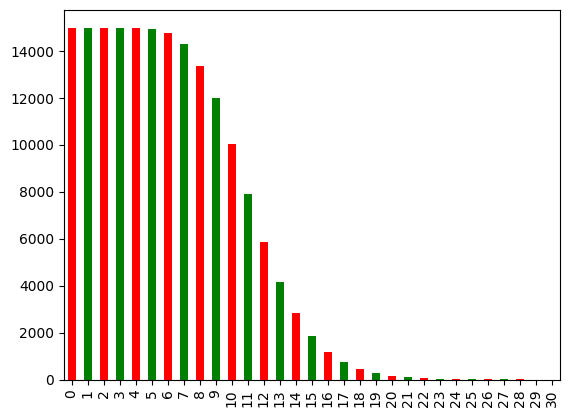

In [ ]:
train_df["line_number"].value_counts().plot(kind="bar",color=["r","g"])

In [ ]:
np.percentile(train_df["line_number"],98)

15.0

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column 
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [ ]:
train_line_numbers_one_hot[:15]

<tf.Tensor: shape=(15, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
train_df.total_lines.value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

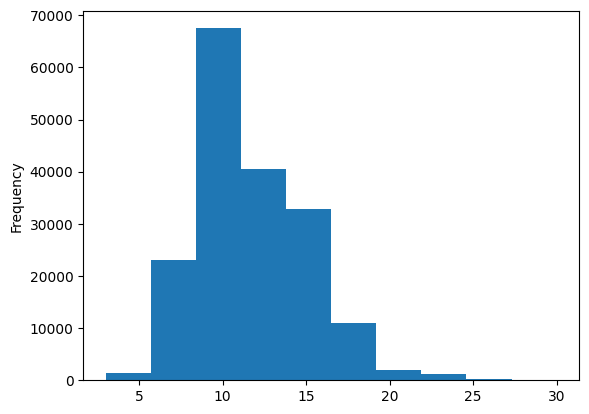

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:
np.percentile(train_df["total_lines"],98)

20.0

In [ ]:
train_total_lines_one_hot=tf.one_hot(train_df.total_lines.to_numpy(),depth=20)
val_total_lines_one_hot=tf.one_hot(val_df.total_lines.to_numpy(),depth=20)
test_total_lines_one_hot=tf.one_hot(test_df.total_lines.to_numpy(),depth=20)

In [ ]:
train_total_lines_one_hot[:2]

<tf.Tensor: shape=(2, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

###**Building a tribrid embedding model**

In [ ]:
from keras.layers.serialization import activation
# 1.token inputs
token_inputs=layers.Input(shape=[],dtype=tf.string,name="Token_Input_layer")
token_embedded=tf_hub_embedded_layer(token_inputs)
token_outputs=layers.Dense(128,activation="relu",name="Token_Output_layer")(token_embedded)
token_model=tf.keras.Model(token_inputs,token_outputs,name="Token_Model_layer")

# 2.Char inputs 
char_inputs=layers.Input(shape=(1,),dtype=tf.string,name="char_Input_Layer")
char_vector=char_vectorizer(char_inputs)
char_embedding=char_embed(char_vector)
char_bi_lstm=layers.Bidirectional(layers.LSTM(24))(char_embedding)
char_model=tf.keras.Model(char_inputs,char_bi_lstm,name="char_model_layer")

# 3. Line_number_inputs
line_number_inputs=layers.Input(shape=(15,),dtype=tf.float32,name="Line_Number_Input")
x=layers.Dense(64,activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x,name="Line_Number_Model_Layer")
# 4. Total lines inputs
total_lines_inputs=layers.Input(shape=(20,),dtype=tf.float32,name="Total_Line_Input")
y=layers.Dense(64,activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y,name="Total_Line__Model_Layer")

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings=layers.Concatenate(name="token_char_hybrid_embedding") ([token_model.output,
                                                                            char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_lines_model.output,
                                                                z])

# 7. Create output layer
output_layer=layers.Dense(5,activation="softmax",name="Output_Layer")(z)

model_5=tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)


In [ ]:
model_5.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_Input_Layer (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 Token_Input_layer (InputLayer)  [(None,)]           0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_Input_Layer[0][0]']       
 tion)                                                                                            
                                                                                                  
 universal-sentence-encoder (Ke  (None, 512)         256797824   ['Token_Input_layer[0][0]']

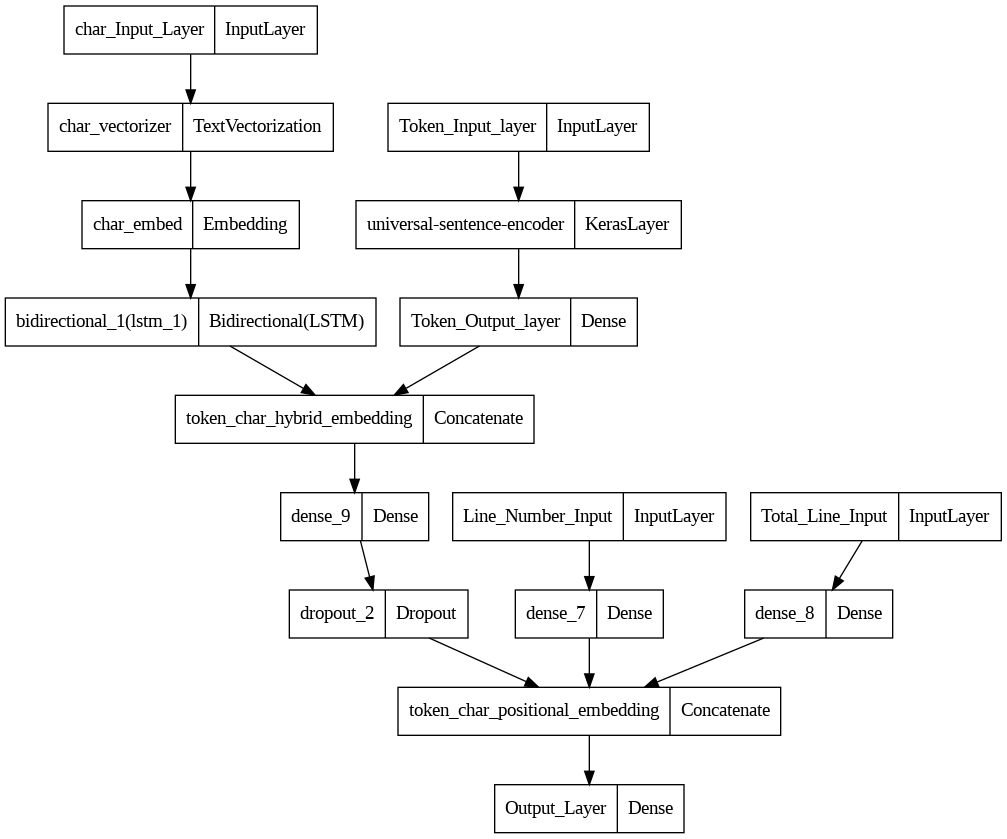

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [ ]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
     

In [ ]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_char)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_char))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 31s 40ms/step - loss: 1.0815 - accuracy: 0.7355 - val_loss: 0.9768 - val_accuracy: 0.8072
Epoch 2/3
562/562 [==============================] - 29s 51ms/step - loss: 0.9622 - accuracy: 0.8183 - val_loss: 0.9461 - val_accuracy: 0.8328
Epoch 3/3
562/562 [==============================] - 24s 42ms/step - loss: 0.9472 - accuracy: 0.8264 - val_loss: 0.9380 - val_accuracy: 0.8311


In [ ]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 22s 23ms/step


array([[0.4961519 , 0.10814719, 0.01161306, 0.3636974 , 0.02039048],
       [0.52458733, 0.10413828, 0.04308189, 0.31623405, 0.01195845],
       [0.28615034, 0.11760733, 0.17251734, 0.353654  , 0.07007093],
       ...,
       [0.03291595, 0.0934248 , 0.03743258, 0.033326  , 0.8029007 ],
       [0.03287067, 0.3007745 , 0.07054648, 0.02845655, 0.56735176],
       [0.18790065, 0.634551  , 0.07985037, 0.03597715, 0.06172093]],
      dtype=float32)

In [ ]:

# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

###**Model_5 Results**

In [ ]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.40394545213823,
 'precision': 0.8328872564727929,
 'recall': 0.8340394545213823,
 'f1': 0.8329323178522205}

#**Compare model results**

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": Model_0_results,
                                  "custom_token_embed_conv1d": Model_1_results,
                                  "pretrained_token_embed": Model_2_results,
                                  "custom_char_embed_conv1d": Model_3_results,
                                  "hybrid_char_token_embed": Model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results
     

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,80.044353,0.799946,0.800444,0.797237
pretrained_token_embed,73.275520,0.729104,0.732755,0.727076
custom_char_embed_conv1d,68.019330,0.684100,0.680193,0.676926
hybrid_char_token_embed,73.980538,0.735554,0.739805,0.732818
tribrid_pos_char_token_embed,83.403945,0.832887,0.834039,0.832932


In [ ]:

# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

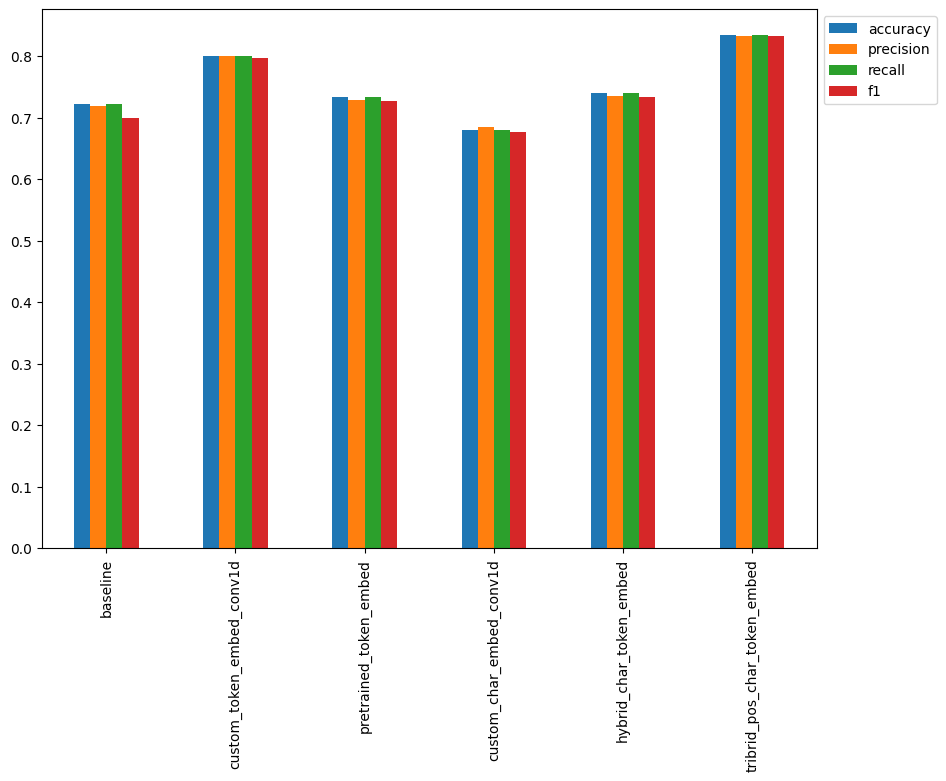

In [ ]:
all_model_results.plot(kind="bar",figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

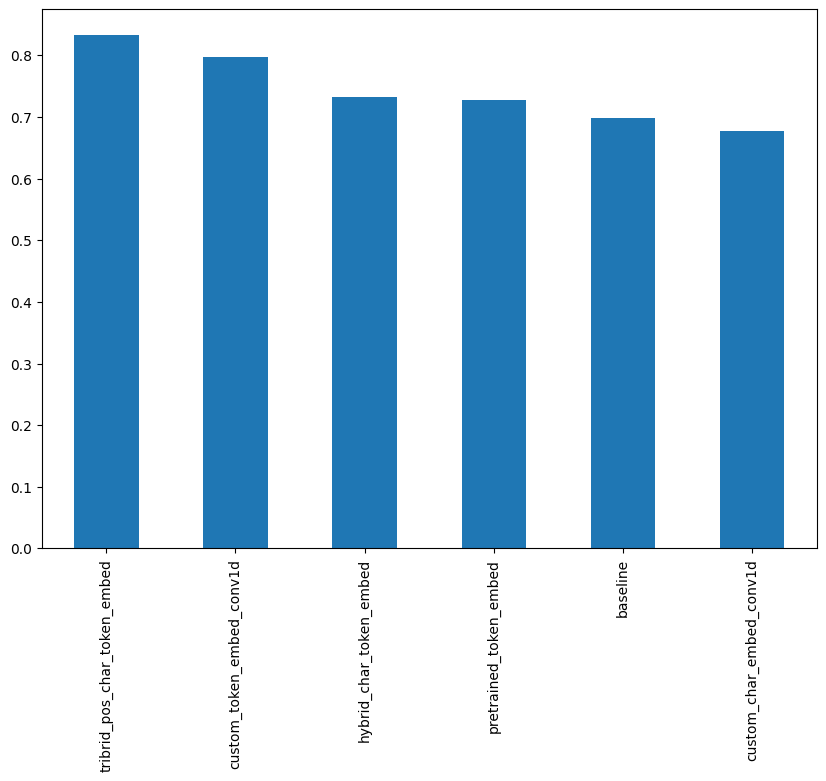

In [ ]:

# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

#**Evaluate model on test dataset**

In [ ]:
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_char))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

# Make predictions on the test dataset
test_pred_probs = model_5.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 16s 17ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 3, 2, 2, 4, 4, 4, 1, 1, 0])>

In [ ]:

# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results
     

{'accuracy': 82.25651236104198,
 'precision': 0.824207238816411,
 'recall': 0.8225651236104198,
 'f1': 0.8215441016835319}